# IVADO Labs assignment
##François-Joseph Lacroix

In [0]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


# Data fetching


In [0]:
class WikipediaTable:

  def __init__(self, soupTable):
    self.soupTable = soupTable
    self.columns = ['MuseumName', 'MuseumNameRef', 'City', 'CityRef', 'VisitorsPerYear', 'ReferenceYear']
    self.museumNames = []
    self.museumNamesRef = []
    self.cities = []
    self.citiesRef = []
    self.nbVisitors = []
    self.referenceYears = []
    self.contents = {}

    self.buildContents()
    self.pdTable = pd.DataFrame(self.contents, columns = self.columns)


  def buildContents(self):
    rows = self.soupTable.find_all('tr')
    del rows[0]

    for row in rows:
      self.buildRow(row)

    self.contents[self.columns[0]] = self.museumNames
    self.contents[self.columns[1]] = self.museumNamesRef
    self.contents[self.columns[2]] = self.cities
    self.contents[self.columns[3]] = self.citiesRef
    self.contents[self.columns[4]] = self.nbVisitors
    self.contents[self.columns[5]] = self.referenceYears



  def buildRow(self, row):

    #Find all columns in this row
    data = row.find_all('td')

    #Extract data and metadata from each column
    museumNameData = data[0].find('a', href=True, recursive=False)
    cityData = data[1].find('a', href=True, recursive=False)
    visitorsData = data[2].getText()

    #Remove <sup> tag
    data[3].find('sup').decompose()
    referenceYearData = data[3].getText()

    #Assign data to correct column
    museumName = museumNameData.getText()
    self.museumNames.append(museumName)
    museumNameRef = museumNameData["href"]
    self.museumNamesRef.append(museumNameRef)

    city = cityData.getText()
    self.cities.append(city)
    cityRef = cityData["href"]
    self.citiesRef.append(cityRef)

    visitorsData = visitorsData.replace(',','')
    nbVisitorsForMuseum = eval(visitorsData)
    self.nbVisitors.append(nbVisitorsForMuseum)

    referenceYear = int(referenceYearData)
    self.referenceYears.append(referenceYear)


  def addWikibaseIds(self, idsDict):

    wikiTable.pdTable["WikibaseId"] = ""

    for index, row in self.pdTable.iterrows():
      wikibaseId = idsDict[self.pdTable.at[index,"CityRef"]]
      self.pdTable.at[index, "WikibaseId"] = wikibaseId

  def assignPopulation(self, populationDict):
    wikiTable.pdTable["Population"] = ""

    for index, row in self.pdTable.iterrows():
      population = populationDict[self.pdTable.at[index,"WikibaseId"]]
      self.pdTable.at[index, "Population"] = population


In [0]:
museumsRequest = requests.get('https://en.wikipedia.org/w/api.php?action=parse&page=List_of_most_visited_museums&prop=text&format=json')
page_content = museumsRequest.json()
page_html = page_content["parse"]["text"]["*"]
soup = BeautifulSoup(page_html)
table = soup.find('table',{'class':'wikitable sortable'})
wikiTable = WikipediaTable(table)

In [0]:
#Load wiki data for wach city from the article
#Query population data for correct year
#If year not available, 

In [0]:
def findWikibaseItemFromArticleName(articleName):
  wikibaseIdURL = "https://www.wikidata.org/w/api.php?action=wbgetentities&sites=enwiki&titles={}&props=descriptions&languages=en&format=json".format(articleName)
  wikibaseRequest = requests.get(wikibaseIdURL)

  wikibaseJson = wikibaseRequest.json()
  wikibaseEntities = wikibaseJson['entities']
  wikibaseItem = list(wikibaseEntities)[0]

  return wikibaseItem

In [0]:
cityWikibaseIds = {}

for index, museum in wikiTable.pdTable.iterrows():
  cityRefOriginal = museum['CityRef']
  cityRef = cityRefOriginal.replace('/wiki/','')

  if cityRefOriginal not in cityWikibaseIds:

    wikibaseItem = findWikibaseItemFromArticleName(cityRef)

    if wikibaseItem == "-1":

      pageIdURL = "https://en.wikipedia.org/w/api.php?action=query&prop=pageprops&titles={}&format=json".format(cityRef)
      pageIdRequest = requests.get(pageIdURL)
      pageIdJson = pageIdRequest.json()
      pages = pageIdJson["query"]['pages']
      pageId = list(pages)[0]

      redirectUrl = "https://en.wikipedia.org/w/api.php?action=query&format=json&pageids={}&redirects".format(pageId)
      redirectRequest = requests.get(redirectUrl)
      redirectJson = redirectRequest.json()

      redirectsTo = redirectJson["query"]['redirects'][0]['to']
      formattedRedirect = redirectsTo.replace(' ', '_')

      wikibaseItem = findWikibaseItemFromArticleName(formattedRedirect)


    cityWikibaseIds[cityRefOriginal] = wikibaseItem


wikiTable.addWikibaseIds(cityWikibaseIds)

In [0]:
class WikipediaDateParser():

  def parse(stringDate):
    
    #Remove + at beginning
    stringDate = stringDate[1:]

    month = stringDate[5:7]
    day = stringDate[8:10]

    if(month == "00"):
      stringDate = stringDate[:5] + "01" + stringDate[7:]
    if(day == "00"):
      stringDate = stringDate[:8] + "01" + stringDate[10:]


    return datetime.strptime(stringDate,'%Y-%m-%dT%H:%M:%SZ')



In [0]:
populationDict = {}

for id in cityWikibaseIds.values():
  populationRequest = requests.get("https://www.wikidata.org/w/api.php?action=wbgetentities&ids={}&format=json".format(id))
  populationJson = populationRequest.json()
  entities = populationJson["entities"]
  entity = entities[list(entities)[0]]
  claims = entity["claims"]
  populationData = claims["P1082"]

  preferredData = None
  newestData = None
  newestDate = WikipediaDateParser.parse('+0001-01-01T00:00:00Z')
  highestPopulation = 0
  preferredFound = False

  for data in populationData:
    if(data["rank"] == "preferred"):
      preferredData = data
      preferredFound = True

    currentPopulationString = data['mainsnak']['datavalue']['value']['amount']
    currentPopulation = eval(currentPopulationString)

    if(currentPopulation > highestPopulation):
      highestPopulation = currentPopulation

    #Check if date is more recent than newest
    try:
      dates = data['qualifiers']['P585']
    except:
      #Mmeans that there is no date available for this population data
      continue

    date = list(dates)[0]
    stringDate = date['datavalue']['value']['time']
    currentDate = WikipediaDateParser.parse(stringDate)
    dateDelta = newestDate - currentDate

    emptyDelta = timedelta()
    if(dateDelta<emptyDelta):
      newestDate = currentDate
      newestData = data

    elif(dateDelta == emptyDelta):
      newestPopulationString = newestData['mainsnak']['datavalue']['value']['amount']
      newestPopulation = eval(newestPopulationString)

      if(currentPopulation>newestPopulation):
        newestDate = currentDate
        newestData = data

  if preferredFound:
    populationString = preferredData['mainsnak']['datavalue']['value']['amount']
    population = eval(populationString)
  else:
    if(newestData is not None):
      populationString = newestData['mainsnak']['datavalue']['value']['amount']
      population = eval(populationString)
    else:
      population = highestPopulation

  populationDict[id] = population


wikiTable.assignPopulation(populationDict)

In [293]:
wikiTable.pdTable

,MuseumName,MuseumNameRef,City,CityRef,VisitorsPerYear,ReferenceYear,WikibaseId,Population
0,Louvre,/wiki/Louvre,Paris,/wiki/Paris,10200000,2018,Q90,2187526
1,National Museum of China,/wiki/National_Museum_of_China,Beijing,/wiki/Beijing,8610092,2018,Q956,21710000
2,Metropolitan Museum of Art,/wiki/Metropolitan_Museum_of_Art,New York City,/wiki/New_York_City,6953927,2018,Q60,8398748
3,Vatican Museums,/wiki/Vatican_Museums,Vatican City,/wiki/Vatican_City,6756186,2018,Q237,1000
4,National Air and Space Museum,/wiki/National_Air_and_Space_Museum,"Washington, D.C.","/wiki/Washington,_D.C.",6200000,2018,Q61,672228
...,...,...,...,...,...,...,...,...
57,Van Gogh Museum,/wiki/Van_Gogh_Museum,Amsterdam,/wiki/Amsterdam,2161160,2018,Q727,860124
58,Tretyakov Gallery,/wiki/Tretyakov_Gallery,Moscow,/wiki/Moscow,2148538,2018,Q649,12500123
59,Shanghai Museum,/wiki/Shanghai_Museum,Shanghai,/wiki/Shanghai,2111730,2018,Q8686,23390000
60,Auschwitz-Birkenau State Museum,/wiki/Auschwitz-Birkenau_State_Museum,Oświęcim,/wiki/O%C5%9Bwi%C4%99cim,2100000,2018,Q7342,39057


# Machine Learning


In [0]:
class CustomLinearRegression():

  def __init__(self, learning_rate=0.005, maxNbIterations=500, epsilon=0.001):
    self.learning_rate = learning_rate
    self.maxNbIterations = maxNbIterations
    self.epsilon = epsilon

  def fit(self, X, Y):
    self.coeff = 0
    self.intercept = 0

    self.loss = self.score(X,Y)

    for i in range (self.maxNbIterations):
      print("Iteration: {}".format(i))

      Y_preds = self.predict(X)

      d_coeff = 0
      d_intercept = 0

      for j in range(len(X)):
        x = X[j]
        y = Y[j]
        y_pred = Y_preds[j]

        d_coeff -= x*(y-y_pred)
        d_intercept -= (y-y_pred)

      d_coeff = (-2/len(X))*d_coeff
      d_intercept = (-2/len(X))*d_intercept

      self.coeff += d_coeff*self.learning_rate
      self.intercept += d_intercept*self.learning_rate

      print("Coefficient derivative: {}".format(d_coeff))
      print("Intercept derivative: {}".format(d_intercept))
      print("Coefficient: {}".format(self.coeff))
      print("Intercept: {}".format(self.intercept))    

      currentLoss = self.score(X, Y)
      print("Loss: {}".format(currentLoss))  

      if(abs(self.loss-currentLoss)<self.epsilon):
        break
      
      self.loss = currentLoss

    return self.loss

  def predict(self, X):
    y = []
    for x in X:
      y_pred = self.coeff*x+self.intercept
      y.append(y_pred)

    return y

  def score(self, X, Y):
    loss = 0

    for i in range(len(X)):
      x = X[i]
      y = Y[i]
      y_pred = self.predict(x)[0]

      loss += (y-y_pred)**2

    loss/=len(X)
    return loss


In [0]:
attendance = wikiTable.pdTable["VisitorsPerYear"].to_numpy()
population = wikiTable.pdTable["Population"].to_numpy()

attendance = attendance.reshape(-1,1)
population = population.reshape(-1,1)
population = np.divide(population, 1000000)
attendance = np.divide(attendance, 1000000)

In [0]:
regr = CustomLinearRegression()

regr.fit(population, attendance) 
print(regr.score(population, attendance)) 

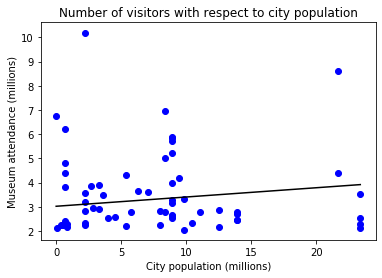

In [297]:
x_pred = [min(population),max(population)]
y_pred = regr.predict(x_pred) 
plt.scatter(population, attendance, color ='b') 
plt.plot(x_pred, y_pred, color ='k') 

plt.title("Number of visitors with respect to city population")
plt.xlabel("City population (millions)")
plt.ylabel("Museum attendance (millions)")

plt.show() 